In [156]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [157]:
anno_g = pd.read_csv("/lustre/grp/tfclab/chenzg/species/mus_musculus/GRCm38.p6/gencode.vM25.genes.tsv", sep="\t", index_col=4)
# anno_g = anno_g[~anno_g.index.duplicated()]
genes = set(anno_g[anno_g["GeneType"].isin(["protein_coding", "lincRNA"])].index)

In [158]:
cts = ["EPI", "PE", "muralTE", "polarTE"]
array = []
for ct in cts:
    path = "../08_blastocyst/results/halflife/%s_genes.gene_name.tsv" % ct
    d = pd.read_csv(path, sep="\t", index_col=0)
    d = d[d.index.isin(genes)]
    d["TPM"] = d["Total"] * 1e6 / d["Total"].sum()
    d = d[d["Total"] >= 20]
    d = d[d["Nascent"] > 0]
    d = d[d["Nascent"] < d["Total"]]
    d["Nascent"] = [max(1, min(total - 1, nascent)) for total, nascent in d[["Total", "Nascent"]].values]
    d["NTR"] = d["Nascent"] / d["Total"]
    d["T"] = -3 / np.log2(1 - d["NTR"])
    d["D"] = np.log(2) / d["T"]
    d["K"] = d["D"] * d["TPM"]
    d.columns = ["%s.%s" % (c, ct) for c in d.columns]
    array.append(d)
dat = pd.concat(array, axis=1, join="inner")
print(len(dat))

4144


In [175]:
m = dat[["TPM.%s" % c for c in cts]]
vs = m.std(axis=1) / m.mean(axis=1)
m1 = m[vs > 0.5]
dat = dat.loc[m1.index]
print(len(dat))

701


In [176]:
cs = []
for c1 in ["K", "D"]:
    for c2 in cts:
        cs.append("%s.%s" % (c1, c2))
m = dat[cs]

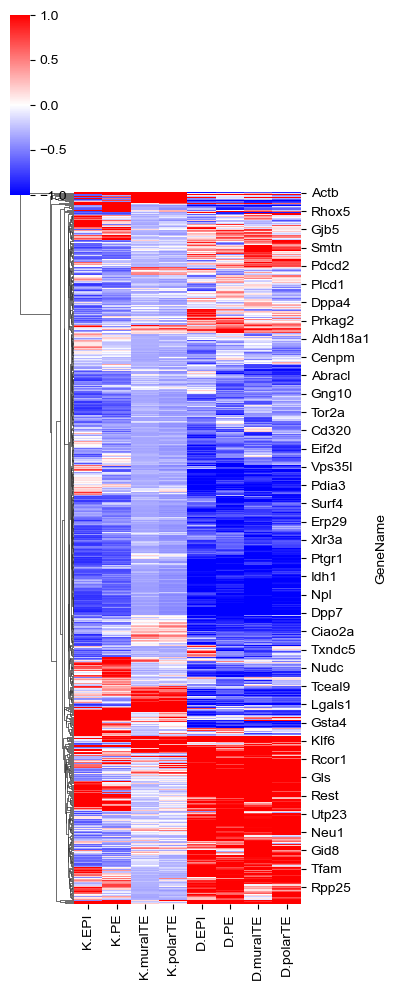

In [177]:
ret = sns.clustermap(m, col_cluster=False, z_score=1, cmap="bwr", vmin=-1, vmax=1, figsize=(4, 10))

In [178]:
zscore = ret.data2d.copy()
tmp = zscore.values
for i in range(tmp.shape[0]):
    for j in range(tmp.shape[1]):
        tmp[i,j] = max(-1, min(1, tmp[i,j]))

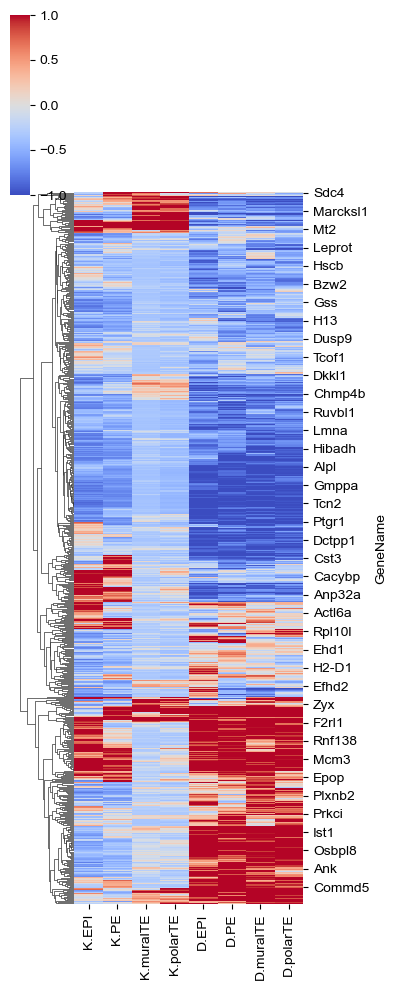

In [180]:
sns.clustermap(zscore, vmin=-1, vmax=1, cmap="coolwarm", figsize=(4, 10), col_cluster=False)

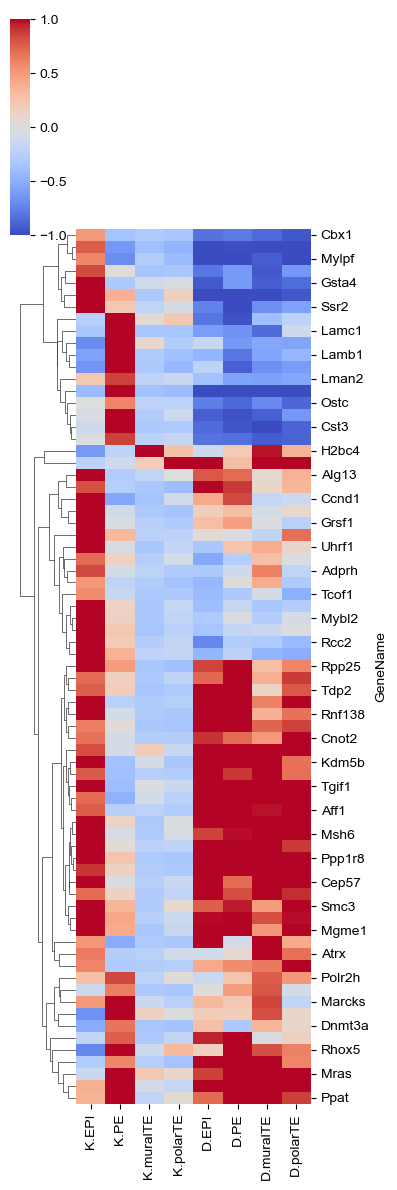

In [181]:
# tmp = zscore[(zscore["K.EPI"] >= 0.5) & (zscore["K.PE"] < 0) & (zscore["K.muralTE"] < 0.1) & (zscore["K.polarTE"] < 0.1)]
# tmp = zscore[(zscore["K.EPI"] < 5) & (zscore["K.PE"] >= 0.5) & (zscore["K.muralTE"] < 0.1) & (zscore["K.polarTE"] < 0.1)]
#tmp = zscore[(zscore["K.EPI"] >= 0.5) & (zscore["K.PE"] < 0) & (zscore["K.muralTE"] < 0.1) & (zscore["K.polarTE"] < 0.1)]
#tmp = zscore[(zscore["K.EPI"] >= 0.5) & (zscore["K.PE"] < 0) & (zscore["K.muralTE"] < 0.1) & (zscore["K.polarTE"] < 0.1)]
flags = []
for vs in zscore[["K.EPI", "K.PE", "K.muralTE", "K.polarTE"]].values:
    vs = list(sorted(vs))
    flags.append(vs[-1] > 0.5 and vs[-1] - vs[-2] > 0.5)
tmp = zscore[flags]
sns.clustermap(tmp, vmin=-1, vmax=1, cmap="coolwarm", col_cluster=False, figsize=(4, 12))

In [182]:
dat.loc["Ppat"]

Total.EPI                                                                171
Nascent.EPI                                                              133
Total.Alleles.EPI          chr5_76914049_T_C_C:26;chr5_76914049_T_C_T:22;...
Nascent.Alleles.EPI        chr5_76914049_T_C_C:20;chr5_76914049_T_C_T:21;...
TPM.EPI                                                           108.174446
NTR.EPI                                                             0.777778
T.EPI                                                               1.382536
K.EPI                                                              54.234246
D.EPI                                                               0.501359
Total.PE                                                                 200
Nascent.PE                                                               168
Total.Alleles.PE           chr5_76914049_T_C_C:34;chr5_76914049_T_C_T:29;...
Nascent.Alleles.PE         chr5_76914049_T_C_C:34;chr5_76914049_T_C_T:25;...